# Create a wind speed and direction plot in Iris

I wrote this tutorial to:

* demonstrate cube arithmetic by the calculation of wind speed
* plotting on a Polar stereo projection with a fancy coastline including ice shelves
* extracting data and coordinates from a cube and manipulating and plotting them directly (the arrows)
* and some additions relating to plot naming

-- by Tony Phillips

In [1]:
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.analysis.cartography
from iris.time import PartialDateTime

import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfe

# print images within notebook
% matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import shiftgrid

# Ignore warning messages for this tutorial (usually we don't do this!)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read wind vectors
filename = 'ECMWF_ERA-40_subset.nc'
u = iris.load_cube(filename, '10 metre U wind component')
v = iris.load_cube(filename, '10 metre V wind component')

iris.FUTURE.cell_datetime_objects = True

period = PartialDateTime(year=2002, month=7, day=1, hour=12)
period_con = iris.Constraint(time=lambda cell: period == cell.point)

# We can use constraints on already loaded cubes
u = u.extract(period_con)
v = v.extract(period_con)

# calculate wind speed and show maximum
ws = (u**2 + v**2) ** 0.5
ws.rename('wind speed')    # name is the CF standard_name for the quantity

# show maximum for first time period so we can choose our contour range
print(ws.data.max())

20.6471889984


# Plot the data

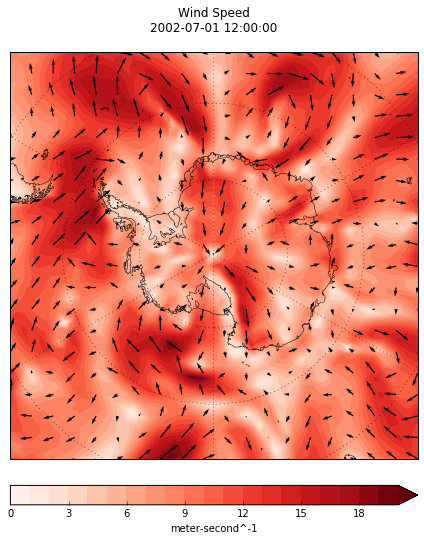

In [3]:
fig = plt.figure(figsize=(6, 8), tight_layout=True)

ax = plt.axes( projection=ccrs.SouthPolarStereo() )
ax.set_extent((-180.0, 180.0, -90.0, -50.0), crs=ccrs.PlateCarree())

contours = iplt.contourf(ws, np.arange( 0, 21, 1), cmap='Reds', extend='max')
cbar = plt.colorbar(contours, orientation='horizontal', pad=0.05)
cbar.set_label(ws.units)

ax.gridlines()
ax.coastlines(resolution='50m', linewidth=0.5)
ax.add_feature(cfe.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', '50m', linewidth=0.5, edgecolor='k', facecolor='none'))

# extract U and V data and co-ordinates so we can plot arrows
Uarr = u.data
Varr = v.data
Xarr = u.coord('longitude').points
Yarr = u.coord('latitude').points

# Shift points and longitudes into range -180=>180 (otherwise arrows for -180=>0 get lost when regrid_shape used)
Ushift, Xshift = shiftgrid(180.0, Uarr, Xarr, start=False)
Vshift, Xshift = shiftgrid(180.0, Varr, Xarr, start=False)

# plot the arrows - note omitting the first and last latitudes as these are the Polar points and cause trouble
arrows = plt.quiver(Xshift, Yarr[1:-1], Ushift[1:-1,:], Vshift[1:-1,:], units='xy', transform=ccrs.PlateCarree(), regrid_shape=20)

# work out date or range of dates for plot title
tc = ws.coord('time')
tu = tc.units
time_str = '{time:%Y-%m-%d %H:%M:%S}'.format(time=tu.num2date(tc.points[0]))

# plot name
cube_name_str = ws[0].name().replace('_', ' ').title()
plt.title(cube_name_str + '\n' + time_str + '\n')

plt.show()